In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'Count']
#urls_train_df = urls_train_df[['id', 'url']]

In [4]:
urls_train_df.head()

,id,url,Count
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1
1,000000014B60815F65B38258011B6C01,rutracker.org,4
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1


In [5]:
urls_train_df.url = urls_train_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))

In [6]:
urls_train_df.url = urls_train_df.url.apply(lambda x: x+" ")
urls_train_df.url = urls_train_df.url.multiply(urls_train_df.Count)
urls_train_df.url = urls_train_df.url.apply(lambda x: x.strip())
urls_train_df.url = urls_train_df.url.apply(lambda x: ' '.join(x.split(' ')))

urls_train_df.url.head()

0                            login.rutracker
1    rutracker rutracker rutracker rutracker
2                             admin.tour-spb
3                                     czinfo
4                                forumsostav
Name: url, dtype: object

In [7]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [8]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [9]:
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [10]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [11]:
train_df.head()

,urls,id,age
0,"[id.rambler, mail.rambler, r0]",000000013CB5719C0000A2C90002C101,53
1,"[1prime, autorambler, chellak, docs.cntd docs....",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen, colady, gorod.dp, i.ovkuse, ...",0000000145BDB2FF000157971645E901,44
4,"[astrorok, diets, edaplus, eshzdorovo, gotovim...",000000014602771F0000DB9359714C01,48


## Снижение размерности

In [12]:
train_df.head()

,urls,id,age
0,"[id.rambler, mail.rambler, r0]",000000013CB5719C0000A2C90002C101,53
1,"[1prime, autorambler, chellak, docs.cntd docs....",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen, colady, gorod.dp, i.ovkuse, ...",0000000145BDB2FF000157971645E901,44
4,"[astrorok, diets, edaplus, eshzdorovo, gotovim...",000000014602771F0000DB9359714C01,48


In [13]:
topk = 300000
X, y = train_df.urls.values[:topk], train_df.age.values[:topk]

In [14]:
X[:5]

array([['id.rambler', 'mail.rambler', 'r0'],
       ['1prime', 'autorambler', 'chellak', 'docs.cntd docs.cntd', 'echo.msk echo.msk', 'expert expert expert expert expert expert expert', 'finance.rambler finance.rambler', 'forbes forbes', 'forum.ixbt', 'garant', 'govoritmoskva', 'kommersant', 'kp', 'lenta', 'mait', 'metronews', 'mk', 'news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler news.rambler', 'news.smi2', 'norm-load', 'pfr.kirov', 'pfrf', 'photography-on-the', 'realty.rambler', 'ren ren ren ren ren', 'riafan', 'rns rns rns rns rns rns rns rns rns rns rns rns rns', 'rossbanki', 'secretmag', 'tehnorma', 'tiu', 'top68', 'tvc', 'tvzvezda', 'vesti', 'video.rambler video.rambler', 'weekend.rambler'],
       ['bosch-korolev'],
       ['aptekanizkihcen', 'colady', 'gorod.dp', 'i.ovkuse', 'love.ma

In [15]:
url_frequency = pd.Series([j for i in X for j in i]).value_counts()

In [16]:
url_frequency.head(10)

mail.rambler                 36966
rambler                      25441
news.rambler                 12965
mail-pda.rambler             12549
id.rambler                   11286
mail.rambler mail.rambler    10997
rambler rambler               7583
images.rambler                7507
rg                            6887
m.rambler                     6844
dtype: int64

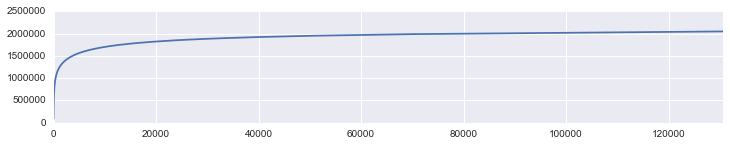

In [16]:
url_frequency = pd.Series([j for i in X for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))

url_frequency.cumsum().plot(figsize=(12,2))

In [17]:
%%time
X = map(lambda x: ' '.join(x), X)
hw = HashingVectorizer(n_features=10000, non_negative=True).fit(X)
X = hw.transform(X).todense()

CPU times: user 22.1 s, sys: 2.65 s, total: 24.7 s
Wall time: 25.4 s


In [18]:
X.shape

(118603, 10000)

In [ ]:
%%time
transformer = sklearn.decomposition.NMF(n_components=500)
X_nmf = transformer.fit_transform(X)

## Холдаут

In [19]:
itrain, itest = cross_validation.train_test_split(range(len(X)), test_size=1./3, random_state=0)
len(itrain), len(itest)

(79068, 39535)

## Обучение модели

In [20]:
rmse(y[itest], np.mean(y[itrain]))

12.546984607126014

In [ ]:
reg = LinearRegression(n_jobs=-1)
reg.fit(X[itrain, :], y[itrain])

pred_X = reg.predict(X[itest, :])
print rmse(y[itest], pred_X)

In [50]:
reg = LinearRegression()
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itest, :])
print rmse(y[itest], pred_X_nmf)

12.0171342861


11.8807182558


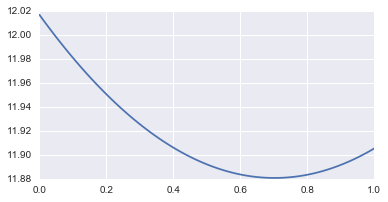

In [64]:
error = []
for w in np.linspace(0, 1, 101):
     error += [rmse(y[itest], pred_X * w + (1-w) * pred_X_nmf)]

pd.Series(error, index=np.linspace(0, 1, 101)).plot(figsize=(6,3))
print min(error)

## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [81]:
from sklearn import pipeline, preprocessing, feature_extraction

In [88]:
##%%time

# обычный датасет
dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :])
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack three models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()
print rmse(y[itest], results)

11.7721541973


In [104]:
stack_ds.X_test.todense().shape

(39535, 3)

In [107]:
results[:10]

array([ 35.58590565,  35.9381726 ,  36.49681817,  33.0223584 ,
        35.9381726 ,  41.72288112,  35.82528573,  35.73381191,
        32.12228247,  36.9305902 ])

### Обучаем на все

In [195]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df = urls_test_df[['id', 'url']]

In [196]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_test_df['id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'Id']

In [163]:
urls_test_df.head()

,urls,Id
0,"[1000bankov.ru, 1tv.ru, 4put.ru, argumenti.ru,...",000000014A02348E701552980349FF01
1,"[autorambler.ru, bilettorg.ru, dsol-druzhba.ru...",000000014A10EA183BF8594A0B2AB201
2,"[photosight.ru, rambler.ru]",000000014A4FE5C33A929D4C26943601
3,"[base.consultant.ru, dogovor-obrazets.ru, fd.r...",000000014B7BB9957784A9BC0AC9F401
4,"[assessor.ru, audit-it.ru, base.garant.ru, com...",000000014C7749F896D82C2B01E8B801


In [131]:
Xtest = urls_test_df.urls.values
Xtest = map(lambda x: ' '.join(x), Xtest)
Xtest = hw.transform(Xtest).todense()

In [132]:
Xtest.shape

(19974, 1000)

In [136]:
%%time
Xtest_nmf = transformer.fit_transform(Xtest)

CPU times: user 4min 38s, sys: 4.03 s, total: 4min 42s
Wall time: 2min 38s


In [138]:
%%time

# обычный датасет
dataset1 = Dataset(X, y, Xtest)
# NMF
dataset2 = Dataset(X_nmf, y, Xtest_nmf)

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack three models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()
#print rmse(y[itest], results)

CPU times: user 25min 6s, sys: 12.7 s, total: 25min 19s
Wall time: 6min 59s


In [140]:
results.shape

(19974,)

In [141]:
results

array([ 41.82202794,  39.08557291,  39.85694001, ...,  35.09035561,
        36.68318542,  41.1231326 ])

In [142]:
3815./5727

0.6661428321983587

In [164]:
sample_df = pd.read_csv('sample_submission.csv')

In [165]:
sample_df.head()

,Id,age
0,000000014A02348E701552980349FF01,36.04347
1,000000014A10EA183BF8594A0B2AB201,36.04347
2,000000014A4FE5C33A929D4C26943601,36.04347
3,000000014B7BB9957784A9BC0AC9F401,36.04347
4,000000014C7749F896D82C2B01E8B801,36.04347


In [178]:
sample_df.age.shape

(19979,)

In [197]:
miss_idx = set(sample_df.Id.values) - set(urls_test_df.Id.values)
miss_idx  ## есть 

{'00000001545483F30F717F5A0721E401',
 '00000046549F9C26429C4B0159BFEE01',
 '000000465684D839B64B58DA9701F701',
 '000022D456544DE3771122F857A6F201',
 '06210D9556EFE0E30000054678B0D901'}

In [198]:
miss_df = pd.DataFrame(zip(list(miss_idx), age_train_df.age.mean()* np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [199]:
miss_df

,Id,age
0,000022D456544DE3771122F857A6F201,36.04347
1,06210D9556EFE0E30000054678B0D901,36.04347
2,00000046549F9C26429C4B0159BFEE01,36.04347
3,00000001545483F30F717F5A0721E401,36.04347
4,000000465684D839B64B58DA9701F701,36.04347


In [205]:
urls_test_df["age"] = results

In [208]:
urls_test_df.head()

,urls,Id,age
0,"[1000bankov.ru, 1tv.ru, 4put.ru, argumenti.ru,...",000000014A02348E701552980349FF01,41.822028
1,"[autorambler.ru, bilettorg.ru, dsol-druzhba.ru...",000000014A10EA183BF8594A0B2AB201,39.085573
2,"[photosight.ru, rambler.ru]",000000014A4FE5C33A929D4C26943601,39.856940
3,"[base.consultant.ru, dogovor-obrazets.ru, fd.r...",000000014B7BB9957784A9BC0AC9F401,32.394220
4,"[assessor.ru, audit-it.ru, base.garant.ru, com...",000000014C7749F896D82C2B01E8B801,37.584678


In [209]:
all_set = urls_test_df.merge(miss_df, how='outer')[["Id", "age"]]

In [213]:
all_set.sort_values(by="Id").to_csv("stacking_baseline.csv", index=False)